In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from NPw_aux import prepare_ion_data
import warnings
import os
warnings.filterwarnings("ignore")
import logging
datapath = os.environ.get("DATA_PATH")
if datapath == None:
    raise KeyError("Enviromental variable data path has to be declared")
print(datapath)
from datetime import datetime, timedelta
freq = timedelta(minutes=30)
logging.disable(logging.CRITICAL)

/home/carloscano/data/


In [2]:
#df_GNSSTEC,df_covariate, df_eq = prepare_ion_data(datapath, "GRK", freq)

In [3]:
#df_GNSSTEC.to_pickle("df_GNSSTEC.pkl")
#df_covariate.to_pickle("df_covariate.pkl")
#df_eq.to_pickle("df_eq.pkl")

In [4]:
import pandas as pd
df_GNSSTEC = pd.read_pickle("../data_test/df_GNSSTEC.pkl")
df_covariate = pd.read_pickle("../data_test/df_covariate.pkl")
df_eq = pd.read_pickle("../data_test/df_eq.pkl")
n_forecasts = 48


In [5]:
%matplotlib inline
from aux_function_SR import read_data, get_eq_filtered, SR_SENSORS
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level, save, load
import logging
import pandas as pd

import pickle
from NPw import NPw, ConfigEQ, ConfigNPw, ConfigForecast
from dataclasses import dataclass, asdict
from dateutil.relativedelta import *

import ast

import sys
import dateutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler,MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

from NPw import NPw

import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from NPw_aux import prepare_EQ, ConfigEQ


In [6]:

ConfigEQ_d = {
    "dist_start": 1000,
    "dist_delta": 3000,
    "mag_start": 4.5,
    "mag_delta": 2,
    "filter": 1,
    "drop": ["arc_cos", "arc_sin"],
}
config_events = ConfigEQ(**ConfigEQ_d)

df_regressor = df_GNSSTEC.reset_index()
df_other = df_covariate
df_events = prepare_EQ(df_eq, config_events)    
 
forecast_length = timedelta(hours=24)
question_mark_length = timedelta(hours=24)
# Time to take into account to predict 
historic_lenght =  timedelta(days=5)
training_lenght = timedelta(days=30)

In [7]:
from darts import TimeSeries

In [9]:
from DartsFCeV import NLinearDartsFCeVConfig,TransformerDartsFCeVConfig, DartsFCeVConfig,NHITSDartsFCeVConfig, NBEATSDartsFCeVConfig,RNNDartsFCeVConfig,TCNDartsFCeVConfig, TFTDartsFCeVConfig

from FCeV import FCeV, FCeVConfig

TCN_darts_FCeV_config = {
"dilation_base": 2,
"weight_norm": True,
#"kernel_size": 16,
#"num_filter": 1000
}


RNN_darts_FCeV_config = {
     "RNNmodel": "RNN"
}
RNN_darts_FCeV_config = RNNDartsFCeVConfig(**RNN_darts_FCeV_config)

NBEATS_darts_FCeV_config = {
    "num_stacks": 10,
    #"num_layers": 10,
    "num_blocks": 10,
    #"layer_widths": 10,
    "expansion_coefficient_dim": 10
}


NHITS_darts_FCeV_config = {
    "num_stacks": 10,
    #"num_layers": 10,
    "num_blocks": 10,
    #"layer_widths": 10,
    "expansion_coefficient_dim": 10,
    "max_pool_1d": True
}

TFT_darts_FCeV_config = {
    #"lstm_layers" : 2,
    #"hidden_size" : 64,
    "num_attention_heads" : 4,
    "full_attention" : False,
    "add_relative_index": False,
    "hidden_continuous_size" : 8,
}
TFT_darts_FCeV_config = TFTDartsFCeVConfig(**TFT_darts_FCeV_config)


NLinear_darts_FCeV_config = {
"const_init": True,
}
TCN_darts_FCeV_config = TCNDartsFCeVConfig(**TCN_darts_FCeV_config)



NBEATS_darts_FCeV_config = NBEATSDartsFCeVConfig(**NBEATS_darts_FCeV_config)

NHITS_darts_FCeV_config = NHITSDartsFCeVConfig(**NHITS_darts_FCeV_config)


NLinear_darts_FCeV_config = NLinearDartsFCeVConfig(**NLinear_darts_FCeV_config)
 #assert self.head_dim * num_heads == self.embed_dim, 
Transformer_darts_FCeV_config = {
    #"d_model": 12,
    "n_head_divisor": 6,
    #"num_encoder_layers": 3,
    #"num_decoder_layers": 3,
    "dim_feedforward": 512
}
Transformer_darts_FCeV_config = TransformerDartsFCeVConfig(**Transformer_darts_FCeV_config)

darts_FCev_config = {
    "DartsModelConfig": Transformer_darts_FCeV_config,
    "dropout":0.2,
    "n_epochs":300,
    "n_layers": 1,
    "internal_size": 20,
    "batch_size":2400 ,
    "learning_rate": 1e-3,
    "use_gpu": True,
    "event_type": "Non-Binary",
    "patience":30,
    "seed": 1234567,
    "probabilistic": True,
    "config_synthetic": "constant"
}
darts_FCeV_config = DartsFCeVConfig(**darts_FCev_config)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
train_day = datetime.fromisoformat("2018-10-01T00:00:00")
val_day = datetime.fromisoformat("2019-01-01T00:00:00")
forecast_length = timedelta(hours=24)
question_mark_length = timedelta(hours=24)
# Time to take into account to predict 
historic_lenght =  timedelta(days=2)
training_lenght = timedelta(days=38 * 3)
freq = pd.Timedelta(minutes=30)

FCev_config = {
    "freq": freq,
    "forecast_length": forecast_length,
    "question_mark_length": question_mark_length,
    "training_length": training_lenght,
    "verbose": True,
    "input_length": historic_lenght
}


FCev_config = FCeVConfig(**FCev_config)

In [11]:
df_covariate.columns

Index(['GRK', 'Kp', 'f107', 'N sunspot'], dtype='object')

In [12]:
#synthetic_events = pd.read_pickle("../data_test/synthetic.pkl")
#df_synth = prepare_EQ(synthetic_events, config_events)  
output_path = "results/"
synthetic_events = df_covariate[["f107"]].quantile([.1,0.25, .5,0.75, .9])#.drop(["count", "std"])
synthetic_events = pd.DataFrame(np.linspace(60, 80, 21), columns= ["f107"])
df_events = pd.DataFrame(df_covariate["f107"])

current_fcev = FCeV(FCev_config, darts_FCeV_config, df_GNSSTEC, df_covariate.drop("f107", axis = 1),df_events,  output_path, synthetic_events)

In [13]:
import pandas_bokeh
import pandas as pd
pandas_bokeh.output_notebook()
pd.plotting.output_notebook()
pd.set_option('plotting.backend', 'pandas_bokeh')
pd.options.plotting.backend = "plotly" 
df_events.plot()

Loading BokehJS ...

Loading BokehJS ...

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=f107<br>ds=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'f107',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> f107 <i style="color:#fc9944">~2D</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '5e2da54b-f8fe-42be-a778-8782e0bd80e5',
              'x': array([datetime.datetime(2016, 1, 1, 0, 0),
                          datetime.datetime(2016, 1, 2, 0, 0),
                          datetime.datetime(2016, 1, 3, 23, 30), ...,
                          datetime.datetime(2020, 12, 29, 7, 0),
                          datetime.datetime(2020, 12, 31, 3, 0),
                          datetime.datetime(2021, 1, 1, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([95.1, 96.6, 98.5, ..., 8

In [14]:
current_fcev.create_folds(pd.Timestamp(2019,3,16, 12, 0), 100)
print(current_fcev.folds.iloc[0])
from darts import TimeSeries

2016-01-01 00:00:00
start_date   2018-11-29
end_date     2019-03-23
Name: 0, dtype: datetime64[ns]


In [15]:

iteration = 0
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(3600)
def train_with_timeout(fcev_instance, iteration):
    df_fore = current_fcev.process_fold(iteration)
    return df_fore

In [16]:
try:
    df_fore = train_with_timeout(current_fcev, iteration)
except FunctionTimedOut: 
    print(np.nan)
    #sys.exit(0)
    #Missing covariates; could not find past covariates in index value range: 2019-11-02 14:30:00 - 2019-11-04 14:00:00.

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...


In [16]:
df_main = df_fore["BASE"]
from FCeV import METRICS
current_ts = TimeSeries.from_dataframe(df_main["current"])
all_ts_base = current_fcev.FCeV_model.input_series.drop_after(current_ts.start_time())
all_ts_base = all_ts_base.append(current_ts)
all_ts_real, _ = current_fcev.FCeV_model.input_series.split_after(current_ts.end_time())

NameError: name 'df_fore' is not defined

34.36636


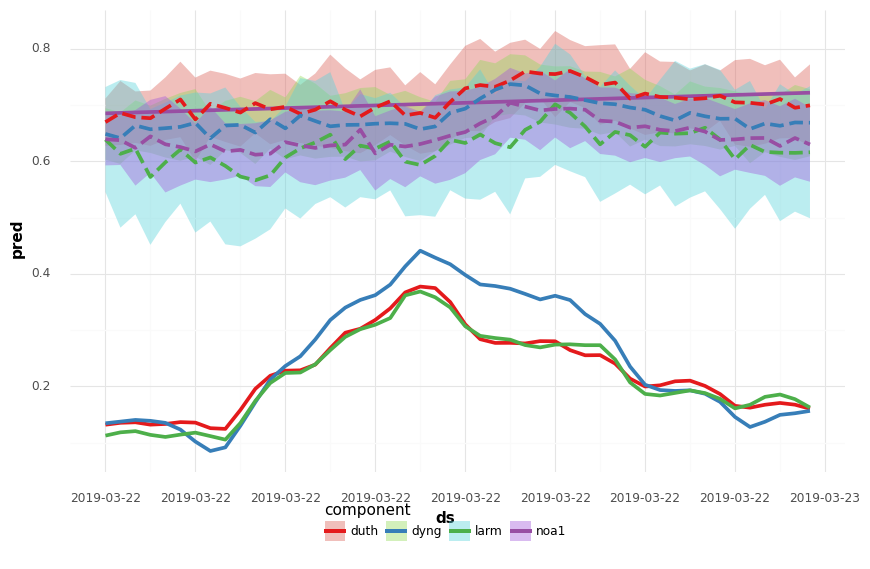

<ggplot: (8764706688130)>

In [22]:
from FCeV import METRICS
df_main = df_fore["EMPTY"]
print(current_fcev.get_metrics_from_fc(df_main["current"], df_main["pred"], METRICS.RMSE).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

24.76557


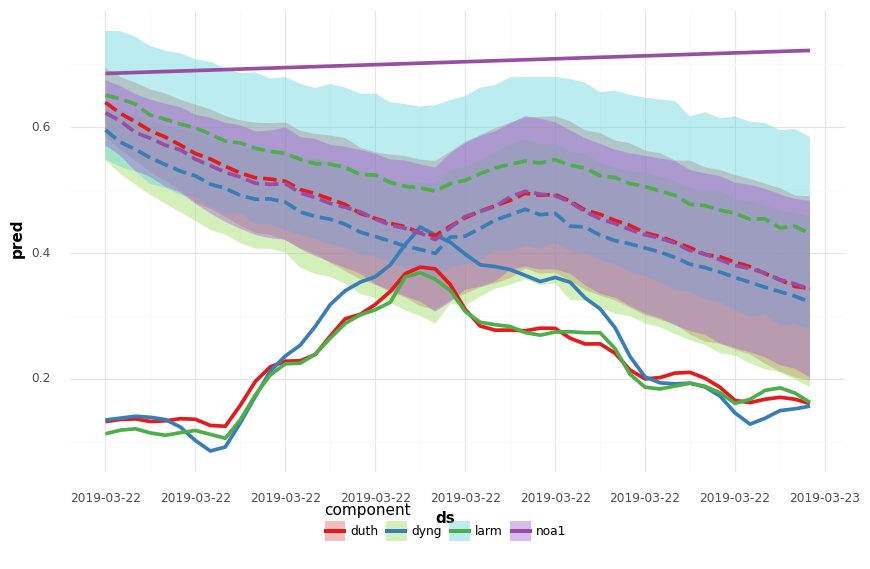

<ggplot: (8764067509480)>

In [19]:
df_main = df_fore["BASE"]
print(current_fcev.get_metrics_from_fc(df_main, METRICS.RMSE).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

33.568974


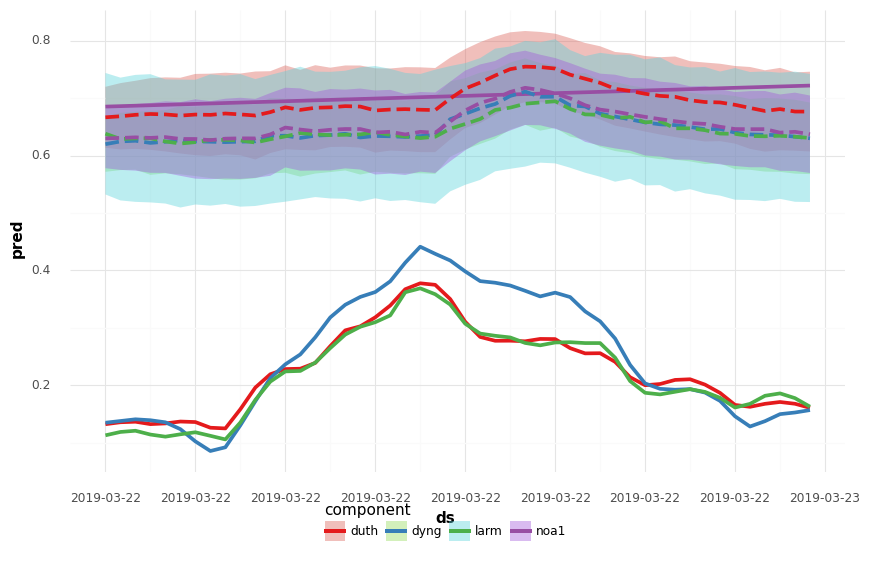

<ggplot: (8764067421534)>

In [20]:
df_main = df_fore["2"]["2"]
print(current_fcev.get_metrics_from_fc(df_main, METRICS.RMSE).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

27.18351


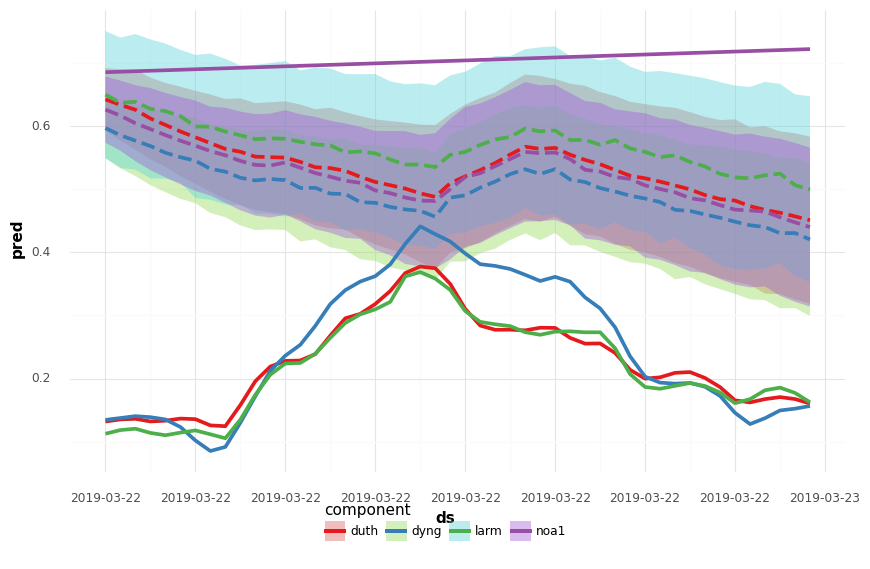

<ggplot: (8764066889171)>

In [21]:
df_main = df_fore["6"]["6"]
print(current_fcev.get_metrics_from_fc(df_main, METRICS.RMSE).mean().mean())
plot = current_fcev.plot_results(df_main)
plot

In [22]:
len(all_ts_real)

56400

In [106]:
real = current_fcev.FCeV_model.input_series

In [107]:
iterations = current_fcev.iterations

In [ ]:
values = current_fcev.FCeV_model.model.predict(n=48, num_samples=1000).plot()


In [ ]:
day = iterations.iloc[iteration].end_date

In [ ]:
real.slice(day - pd.Timedelta(days = 4), day).plot()

## SALES EXAMPLE

In [ ]:
datapath_sales = "/home/carloscano/data/kaggle/store-sales-time-series-forecasting/"

In [ ]:
df_train =  pd.read_csv(datapath_sales + "train.csv", parse_dates=["date"]).rename(columns = {"date":"ds"})
df_test =  pd.read_csv(datapath_sales + "test.csv", parse_dates=["date"]).rename(columns = {"date":"ds"})


In [ ]:
df_test["ds"]

In [ ]:
df_train["family"].unique()

In [ ]:
df_train["store_nbr"].max()

#AUTOMOTIVE - 11

#Electronics index: 47 - 

import time
for i in range(1, 55):
    df_train_selected = df_train[(df_train["store_nbr"] == i) &(df_train["family"] == "BOOKS") ]
    df_train_selected = df_train_selected.reset_index().drop(["store_nbr", 'family', "id", "index"], axis = 1).set_index("date")
    total_prom = np.sum(df_train_selected["onpromotion"] > 0)
    total_value = np.sum(df_train_selected["onpromotion"])
    print(f"index: {i} - {total_value} / {total_prom}")

In [ ]:
df_train_selected = df_train[(df_train["store_nbr"] == 54) & ((df_train["family"] == "AUTOMOTIVE")) ]
df_train_selected = df_train_selected.reset_index().drop(["store_nbr", 'family', "id", "index"], axis = 1).set_index("ds")
df_signal = df_train_selected.drop("onpromotion", axis =1) #["sales"]
df_events = df_train_selected[df_train_selected["onpromotion"] > 0].drop("sales", axis = 1)
df_events["onpromotion"] = (df_events["onpromotion"] > 0)
df_events["onpromotion"] = 1

In [ ]:
df_cov1 = df_train[(df_train["store_nbr"] == 54) & ((df_train["family"] == "BREAD/BAKERY")) ]
df_cov1 = df_cov1.reset_index().drop(["store_nbr", 'family', "id", "index", "onpromotion"], axis = 1).set_index("ds")
df_cov2 = df_train[(df_train["store_nbr"] == 1) & ((df_train["family"] == "AUTOMOTIVE")) ]
df_cov2= df_cov2.reset_index().drop(["store_nbr", 'family', "id", "index", "onpromotion"], axis = 1).set_index("ds")

df_covariates = pd.concat([df_cov1, df_cov2], axis = 1)
df_covariates.columns =  ["bread_54", "auto_1"]

In [ ]:
from DartsFCeV import NLinearDartsFCeVConfig,TransformerDartsFCeVConfig, DartsFCeVConfig,NHITSDartsFCeVConfig, NBEATSDartsFCeVConfig,RNNDartsFCeVConfig,TCNDartsFCeVConfig, TFTDartsFCeVConfig

from FCeV import FCeV, FCeVConfig

TCN_darts_FCeV_config = {
"dilation_base": 2,
"weight_norm": True,
#"kernel_size": 16,
#"num_filter": 10
}
TCN_darts_FCeV_config = TCNDartsFCeVConfig(**TCN_darts_FCeV_config)
RNN_darts_FCeV_config = {
     "RNNmodel": "GRU"
}

RNN_darts_FCeV_config = RNNDartsFCeVConfig(**RNN_darts_FCeV_config)

TFT_darts_FCeV_config = {
    #"lstm_layers" : 2,
    #"hidden_size" : 64,
    "num_attention_heads" : 6,
    "full_attention" : False,
    "add_relative_index": False,
    "hidden_continuous_size" : 2,
}
TFT_darts_FCeV_config = TFTDartsFCeVConfig(**TFT_darts_FCeV_config)



darts_FCev_config = {
    "DartsModelConfig": RNN_darts_FCeV_config,
    "dropout":0.1,
    "n_epochs":1000,
    "n_layers": 1,
    "internal_size": 28,
    "batch_size":600 ,
    "learning_rate": 1e-2,
    "use_gpu": True,
    "event_type": "Non-Binary",
    "patience":30,
    "seed": 1234567,
    "probabilistic": True
}

darts_FCeV_config = DartsFCeVConfig(**darts_FCev_config)
forecast_length = timedelta(hours=24 * 3)
question_mark_length = timedelta(hours=24 * 3)
# Time to take into account to predict 
historic_lenght =  timedelta(days=32)
training_lenght = timedelta(days=798)
freq = pd.Timedelta(days=1)

FCev_config = {
    "freq": freq,
    "forecast_length": forecast_length,
    "question_mark_length": question_mark_length,
    "training_length": training_lenght,
    "verbose": False,
    "input_length": historic_lenght
}

FCev_config = FCeVConfig(**FCev_config)

In [12]:
df_synth = pd.DataFrame([1], columns = ["onpromotion"])

In [659]:
df_synth

NameError: name 'df_synth' is not defined

In [13]:
os.getcwd()

'/home/carloscano/dev/NeuralProphetEQ/notebooks'

In [112]:
import datetime
output_path = "/home/carloscano/outputs/RNN_TEC_constant/"
#current_fcev = FCeV(FCev_config, darts_FCeV_config, df_signal, df_covariates,df_events,  output_path, df_synth)
df_result = current_fcev.read_result(output_path)

In [220]:
list_values = list()
list_index = list()
list_colums = list()
start_index = df_test.index.mean()
expected = df_events.loc[df_test.index]for name, group in df_test.drop(["BASE", "EMPTY"], axis = 1).groupby(level='CF', axis = 1):
    pred = group[name]["pred"]
    current = group[name]["current"]
    uncer = group[name]["uncer"]
    value = 0 # np.random.normal(0, 1, 4)
    simulation = pred + value * uncer
    curret_metrics = current_fcev.get_metrics_from_fc(current, simulation, current_metric).mean(1).mean()
    list_values.append(pd.DataFrame(curret_metrics, columns = synthetic_events_ref.loc[name].values, index = [start_index]))
#list_values.append(pd.DataFrame(expected.mean().values, columns = ["expected"], index = [start_index]))
df_out = pd.concat(list_values, axis = 1)
df_out["pred"] = df_out.idxmin(1).values[0]
df_out["current"] = expected.mean().values[0]

f107    67.55
dtype: float64

In [ ]:
synthetic_events_ref = synthetic_events.copy()
synthetic_events_ref.index = [f"{index}_{index}" for index in synthetic_events_ref.index]

In [345]:
from FCeV import METRICS
current_metric = METRICS.RMSE
df_test = df_result.head(48)
list_values = list()
list_index = list()
list_colums = list()
start_index = df_test.index.mean()
expected = df_events.loc[df_test.index]
input_length = 48

In [352]:
df_result

CF                       BASE                                          \
type                  current                                    pred   
component                larm      dyng      duth      noa1      larm   
ds                                                                      
2017-12-31 12:00:00  0.919814  0.872521  0.863932  0.845448  0.897375   
2017-12-31 12:30:00  0.932466  0.889317  0.883723  0.856849  0.918443   
2017-12-31 13:00:00  0.912781  0.876390  0.859803  0.834365  0.931835   
2017-12-31 13:30:00  0.868471  0.850062  0.805363  0.798420  0.947441   
2017-12-31 14:00:00  0.834136  0.834114  0.767764  0.777444  0.954966   
...                       ...       ...       ...       ...       ...   
2020-09-26 09:30:00  0.000000  0.681307  0.737702  0.692214  0.000547   
2020-09-26 10:00:00  0.000000  0.702490  0.740355  0.700191  0.000327   
2020-09-26 10:30:00  0.000000  0.730445  0.753049  0.724116  0.000633   
2020-09-26 11:00:00  0.000000  0.748114  0.770458  0.747239  0.000873   
2020-09-26 11:30:00  0.000000  0.752493  0.783005  0.762036  0.000855   

CF                                                                     ...  \
type                                                  uncer            ...   
component                dyng      duth      noa1      larm      dyng  ...   
ds                                                                     ...   
2017-12-31 12:00:00  0.881631  0.841014  0.860652  0.027124  0.029982  ...   
2017-12-31 12:30:00  0.881745  0.842512  0.884665  0.037662  0.038201  ...   
2017-12-31 13:00:00  0.898398  0.843464  0.888759  0.042062  0.040033  ...   
2017-12-31 13:30:00  0.889946  0.835943  0.907372  0.052513  0.053390  ...   
2017-12-31 14:00:00  0.901921  0.830058  0.897383  0.060256  0.058900  ...   
...                       ...       ...       ...       ...       ...  ...   
2020-09-26 09:30:00  0.442916  0.485224  0.466779  0.003474  0.145479  ...   
2020-09-26 10:00:00  0.444083  0.484323  0.466833  0.003355  0.146306  ...   
2020-09-26 10:30:00  0.453769  0.494848  0.470216  0.003231  0.147538  ...   
2020-09-26 11:00:00  0.456443  0.506501  0.480259  0.003322  0.146204  ...   
2020-09-26 11:30:00  0.480698  0.518864  0.489694  0.003279  0.146771  ...   

CF                        6_6                                          \
type                  current                pred                       
component                duth      noa1      larm      dyng      duth   
ds                                                                      
2017-12-31 12:00:00  0.863932  0.845448  0.716355  0.771957  0.727547   
2017-12-31 12:30:00  0.883723  0.856849  0.793811  0.789858  0.821469   
2017-12-31 13:00:00  0.859803  0.834365  0.869615  0.872177  0.910477   
2017-12-31 13:30:00  0.805363  0.798420  0.923411  0.905113  0.975019   
2017-12-31 14:00:00  0.767764  0.777444  0.975749  0.955684  1.043105   
...                       ...       ...       ...       ...       ...   
2020-09-26 09:30:00  0.737702  0.692214  0.008482 -0.207262 -0.326432   
2020-09-26 10:00:00  0.740355  0.700191  0.008313 -0.215592 -0.328855   
2020-09-26 10:30:00  0.753049  0.724116  0.009033 -0.198296 -0.306992   
2020-09-26 11:00:00  0.770458  0.747239  0.009135 -0.190248 -0.294559   
2020-09-26 11:30:00  0.783005  0.762036  0.010584 -0.167444 -0.275152   

CF                                                                     
type                              uncer                                
component                noa1      larm      dyng      duth      noa1  
ds                                                                     
2017-12-31 12:00:00  0.671405  0.028469  0.032412  0.022130  0.028951  
2017-12-31 12:30:00  0.760268  0.038206  0.042697  0.032488  0.036806  
2017-12-31 13:00:00  0.819295  0.041896  0.043657  0.036304  0.039957  
2017-12-31 13:30:00  0.869005  0.053595  0.052724  0.044705  0.049082  
2017-12-31 14:00:00  0.903807  0.055272  0.051021  0.046694  

In [357]:
df = df_result.copy()
df_results = pd.DataFrame()
from FCeV import METRICS
current_metric = METRICS.RMSE
for index in range(len(df) // input_length):
    df_test = df.iloc[index * input_length: (index + 1) * input_length - 1]
    list_values = list()
    list_index = list()
    list_colums = list()
    start_index = df_test.index.mean()
    expected = df_events.loc[df_test.index]
    for name, group in df_test.drop(["BASE", "EMPTY"], axis = 1).groupby(level='CF', axis = 1):
        pred = group[name]["pred"]
        current = group[name]["current"]
        uncer = group[name]["uncer"]
        value = 0 # np.random.normal(0, 1, 4)
        simulation = pred + value * uncer
        curret_metrics = current_fcev.get_metrics_from_fc(current, simulation, current_metric).mean(1).mean()
        list_values.append(pd.DataFrame(curret_metrics, columns = synthetic_events_ref.loc[name].values, index = [start_index]))
    #list_values.append(pd.DataFrame(expected.mean().values, columns = ["expected"], index = [start_index]))
    df_out = pd.concat(list_values, axis = 1)
    df_out["pred"] = df_out.idxmin(1).values[0]
    df_out["current"] = expected.mean().values[0]
    df_results = pd.concat([df_results, df_out])

In [361]:
df_results.columns

Index([68.0, 70.0, 72.0, 74.0, 76.0, 78.0, 80.0, 'pred', 'current'], dtype='object')

In [371]:
df_results[["pred", "current"]].head(2000).plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=pred<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'pred',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'pred',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '3f28c3af-d264-459b-96e6-edd15b72b1f3',
              'x': array([datetime.datetime(2017, 12, 31, 23, 29, 59, 999999),
                          datetime.datetime(2018, 1, 1, 23, 29, 59, 999999),
                          datetime.datetime(2018, 1, 2, 23, 29, 59, 999999), ...,
                          datetime.datetime(2020, 9, 23, 23, 29, 59, 999999),
                          datetime.datetime(2020, 9, 24, 23, 29, 59, 999999),
                          datetime.datetime(2020, 9, 25, 23, 29, 59, 999999)], dtype=object),
              'xaxis': 'x',
              'y': array([68., 68.

In [378]:
current_fcev.get_metrics_from_fc(df_results["current"], df_results["pred"], current_metric).mean()/100

2.0275127659574466

<AxesSubplot: xlabel='current', ylabel='pred'>

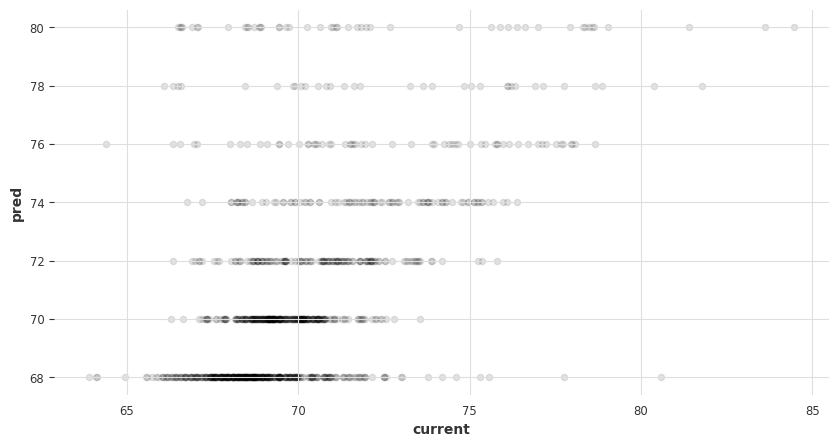

In [399]:

df_results.plot.scatter(x = "current", y = "pred", alpha = 0.1, figsize = (10,5))

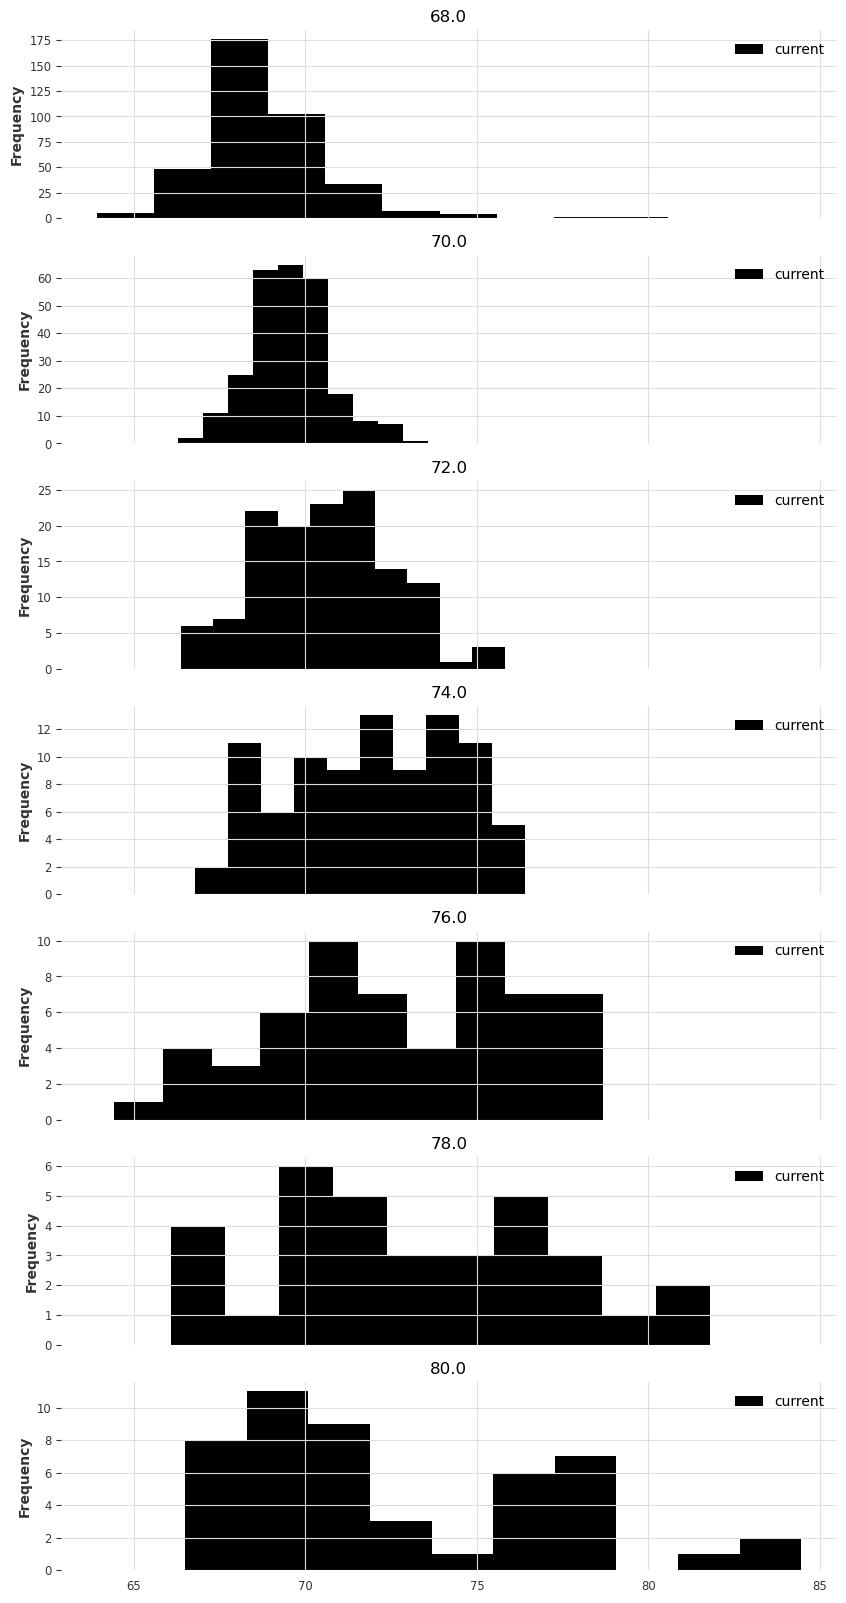

In [410]:
df_results[["pred", "current"]].plot.hist(by=["pred"], figsize = (10, 20), sharex=True);

In [44]:
from darts.ad import KMeansScorer, WassersteinScorer, CauchyNLLScorer
def get_anom(df):
    df = df.sort_index()
    S = 48 * 100
    N = int(len(df)/S)
    frames = [ df.iloc[i*S:(i+1)*S].copy() for i in range(N+1) ]
    frames.pop()
    all_frames = None
    frames = [df]
    for current_df in frames: 
        all_anom_score = None
        for index in range(30):
            ts_current_val = TimeSeries.from_dataframe(current_df["current"])
            ts_pred_val = TimeSeries.from_dataframe(current_df["pred"])
            ts_current_train = current_fcev.FCeV_model.input_series.drop_after(ts_current_val.start_time())
            ts_current_all = ts_current_train.append(ts_current_val)
            ts_base_all = ts_base_train.append(ts_base_val)
            scorer = KMeansScorer(k=3, window=10)
            scorer.fit(ts_current_train)
            anom_score = scorer.score_from_prediction(ts_current_val, ts_base_val)
            if all_anom_score is None:
                all_anom_score = anom_score
            else:
                all_anom_score = all_anom_score.concatenate(anom_score, axis = "component")
        if all_frames is None:
            all_frames = all_anom_score.mean(1)
        else:
            #print(f"end all {all_frames.end_time()} + start_new {all_anom_score.mean(1).start_time()}")
            all_frames = all_frames.append(all_anom_score.mean(1))
    return all_frames.pd_dataframe()

In [45]:
from FCeV import METRICS
metrics = {}
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = value
        current = df["current"]
        pred = df["pred"]
        current_value = current_fcev.get_metrics_from_fc(current, pred, METRICS.RMSE).mean().mean()
        metrics[f"{key}"] = current_value
    else:
        for key_inner, value_inner in value.items():
            current = value_inner["current"]
            pred = value_inner["pred"]
            current_value = current_fcev.get_metrics_from_fc(current, pred, METRICS.RMSE).mean().mean()
            metrics[f"{synthetic_events.iloc[int(key_inner)].item()}"] = current_value


In [46]:
metrics

{'BASE': 14.710709,
 'EMPTY': 22.444054,
 '68.0': 19.770477,
 '70.0': 17.72344,
 '72.0': 20.344654,
 '74.0': 23.290714,
 '76.0': 25.694088,
 '78.0': 27.775642,
 '80.0': 29.59675}

In [47]:
pred_serie = None
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = pd.DataFrame(current_fcev.get_metrics_from_fc(value, METRICS.RMSE).mean(axis = 1))
        df.columns = [f"{key}"]
        if pred_serie is None:
            pred_serie = TimeSeries.from_dataframe(df)
        else:
            pred_serie = pred_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")
    else:
        for key_inner, value_inner in value.items():
            df = pd.DataFrame(current_fcev.get_metrics_from_fc(value_inner, METRICS.RMSE).mean(axis = 1))
            df.columns = [f"{key}_{key_inner}"]
            pred_serie = pred_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")

TypeError: get_metrics_from_fc() missing 1 required positional argument: 'metrics'

In [48]:
anom_serie = None
for key, value in all_dict.items():
    if isinstance(value, pd.DataFrame):
        df = value
        df = get_anom(df)
        df.columns = [f"{key}"]
        if anom_serie is None:
            anom_serie = TimeSeries.from_dataframe(df)
        else:
            anom_serie = anom_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")
    else:
        for key_inner, value_inner in value.items():
            df = get_anom(value_inner)
            df.columns = [f"{key}_{key_inner}"]
            anom_serie = anom_serie.concatenate(TimeSeries.from_dataframe(df), axis = "component")

In [280]:
#val_events = current_fcev.FCeV_model.events.slice_intersect(anom_serie)["pr"]
#anom_serie = anom_serie.concatenate(val_events, axis= "component")

In [281]:
synthetic_events

,f107
0,68.0
1,70.0
2,72.0
3,74.0
4,76.0
5,78.0
6,80.0


In [49]:
next_slice = anom_serie
start_point = anom_serie.start_time()
chunks = list()
chunk_len = 48
total_len = len(anom_serie)
for index in range(total_len // chunk_len  - 1) :
    current_slice, next_slice = next_slice.split_before(chunk_len)
    start_point = current_slice.end_time()
    chunks.append(current_slice.pd_dataframe())

## USING TAB FASTAI

In [419]:
from fastai.tabular.all import *

NameError: name 'df_tab' is not defined

In [651]:
splits = RandomSplitter(valid_pct=0.33)(range_of(df_results))
y_name = "current"
df_tab = df_results.drop("pred",axis = 1).copy()
df_test = df_tab.iloc[-200:]
df_tab = df_tab.iloc[:-200 -1]

min_y = np.min(df_tab[y_name]) - 1
#min_y = 0
df_tab[y_name] = np.log(df_tab[y_name] - min_y)

len_train = int(len(df_tab) * 0.8)
df_train = df_tab.iloc[:len_train];
df_val = df_tab.iloc[len_train + 1:];
len_train

639

In [652]:
splits = (L(range(len(df_train))), L(range(len(df_train) + 1, len(df_train) + len(df_val))))
splits

((#639) [0,1,2,3,4,5,6,7,8,9...],
 (#158) [640,641,642,643,644,645,646,647,648,649...])

In [653]:
to = TabularPandas(df_tab, procs=[FillMissing, Normalize],
                   cont_names = list(df_tab.drop(y_name, axis = 1).columns.values),
                   y_block=RegressionBlock(),
                   y_names=y_name,
                   splits=splits)
dls = to.dataloaders(bs=100)

In [658]:
max_log_y = np.max(df_tab[y_name])*1.2
y_range = torch.tensor([0, max_log_y]); y_range
tc = tabular_config(ps=[0.001, 0.01], embed_p=0.04, y_range=y_range)
learn = tabular_learner(dls, layers=[1000,500],
                        metrics=exp_rmspe,
                        config=tc,
                        loss_func=MSELossFlat())

tc = tabular_config(y_range=y_range)
learn = tabular_learner(dls,
                        metrics=exp_rmspe,
                        config=tc,
                        loss_func=MSELossFlat(),
                        verbose = False
                        )
learn.lr_find()

TypeError: __init__() got an unexpected keyword argument 'verbose'

In [655]:

learn.fit_one_cycle(200)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.211491,0.120690,0.772450,00:00
1,0.184498,0.123634,0.793562,00:00
2,0.162514,0.125472,0.804168,00:00
3,0.148225,0.132942,0.815588,00:00
4,0.138823,0.144412,0.813450,00:00
5,0.132622,0.149915,0.789180,00:00
6,0.127144,0.142012,0.726167,00:00
7,0.121689,0.143236,0.715502,00:00
8,0.117658,0.142238,0.727000,00:00
9,0.113231,0.139630,0.757589,00:00


In [657]:
dl = learn.dls.test_dl(df_test)
raw_test_preds = learn.get_preds(dl=dl)
learn.validate(dl=dl)
test_preds = (np.exp(raw_test_preds[0])+ min_y).numpy().T[0]
df_test["new_pred"] = test_preds
pd.options.plotting.backend = "plotly" 
df_test[["current", "new_pred"]].plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=current<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'current',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'current',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '8e10e104-d2b9-49c3-9b67-6bca49e585ba',
              'x': array([datetime.datetime(2020, 3, 10, 23, 29, 59, 999999),
                          datetime.datetime(2020, 3, 11, 23, 29, 59, 999999),
                          datetime.datetime(2020, 3, 12, 23, 29, 59, 999999),
                          datetime.datetime(2020, 3, 13, 23, 29, 59, 999999),
                          datetime.datetime(2020, 3, 14, 23, 29, 59, 999999),
                          datetime.datetime(2020, 3, 15, 23, 29, 59, 999999),
                          datetime.dateti

## Using Pythorch Lightning

In [50]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
from torch import nn
from torch.utils.data import Dataset ,DataLoader
import numpy as np
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from torcheval.metrics import BinaryAccuracy
import torchmetrics
df_input =  anom_serie.pd_dataframe().drop("BASE", axis = 1)
#df_input =  pred_serie.pd_dataframe().drop("BASE", axis = 1)
df_label =  df_events.loc[df_input.index]
channels = len(df_input.columns)
CLASSES = 2
input_length = 48
kernel_size = 10
channel_1 = 64

In [67]:
class CassavaModel(pl.LightningModule):
    def __init__(self):
        
      #image_size = 64
        super().__init__()
        self.cnv = nn.Conv1d(channels,channel_1,kernel_size, padding='same')
        self.rel = nn.ReLU()
        self.bn = nn.BatchNorm1d(64)
        self.mxpool = nn.MaxPool1d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(input_length  * channel_1 // 2,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,1)
        self.softmax = nn.Softmax()
        self.accuracy = BinaryAccuracy()
        self.loss_fn = torch.nn.MSELoss()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):
        out = self.bn(self.rel(self.cnv(x)))
        out = self.flat(self.mxpool(out))
        out = self.dropout(self.rel(self.fc1(out)))
        out = self.dropout(self.rel(self.fc2(out)))
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

    
    def configure_optimizers(self):
        LR = 1e-3
        optimizer = torch.optim.AdamW(self.parameters(),lr=LR)
        return optimizer

    def training_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        
        loss = self.loss_fn(out,label)
        self.log('train_loss', loss)
        return loss       

    def validation_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        loss = self.loss_fn(out,label) 
        self.log('valid_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        preds = self(img)
        preds = self.trainer.datamodule.min_max_scaler_y.inverse_transform(preds.cpu())
        current  = self.trainer.datamodule.min_max_scaler_y.inverse_transform(y.cpu())
        return current, preds
    
    def test_step(self,batch,batch_idx):
        x,y = batch["x"],batch["y"]
        img = x.view(-1,channels,input_length)
        label = y.view(-1)
        out = self(img)
        
        loss = self.loss_fn(out,label)
        self.log('test_loss', loss)
        return loss       

In [68]:
class CassavaDataset(Dataset):
    def __init__(self,df_data, df_events, input_length):
        self.df_data = df_data
        self.df_events = df_events
        self.input_length = input_length
    def __len__(self):
        return len(self.df_data) //  input_length
    
    def __getitem__(self,item):
        #index_selected = [item * input_length : ((item + 1) * input_length)]
        x = self.df_data[item * input_length : ((item + 1) * input_length)].to_numpy()
        y = self.df_events[item * input_length : ((item + 1) * input_length)].mean()

        return {
            "x":torch.tensor(x,dtype=torch.float),
            "y":torch.tensor(y,dtype=torch.float),
        } 

In [69]:
class CassavaLightDataset(pl.LightningDataModule):
    def __init__(self,df_input, df_label,input_length, test_part, batch_size=10):
        super().__init__()
        self.batch_size = batch_size
            
        self.min_max_scaler_y = preprocessing.MinMaxScaler()
        self.min_max_scaler_x = preprocessing.MinMaxScaler()
        self.df_input = df_input
        self.df_label = df_label
        self.test_part = test_part
        self.input_length = input_length

        
    def setup(self,stage=None):
        
        train_X,test_X, train_Y, test_Y  = train_test_split(self.df_input, self.df_label, test_size = self.test_part,shuffle = False)
        
        train_X_scaled = self.min_max_scaler_x.fit_transform(train_X.values)
        df_train_X_scaled = pd.DataFrame(train_X_scaled, columns = train_X.columns, index = train_X.index)
        
        test_X_scaled = self.min_max_scaler_x.transform(test_X.values)
        self.test_X = pd.DataFrame(test_X_scaled, columns = test_X.columns, index = test_X.index)
        
        ## LABEL TRAIN
        train_y_scaled = self.min_max_scaler_y.fit_transform(train_Y.values)
        df_train_y_scaled = pd.DataFrame(train_y_scaled, columns = train_Y.columns, index = train_Y.index)
        
        ## LABEL TEST
        test_y_scaled = self.min_max_scaler_y.transform(test_Y.values)
        self.test_Y = pd.DataFrame(test_y_scaled, columns = test_Y.columns, index = test_Y.index)
        
        self.train_X,self.val_X, self.train_Y, self.val_Y   = train_test_split(df_train_X_scaled,df_train_y_scaled, test_size = 0.1,shuffle = True)
        
        self.train_dataset = CassavaDataset(self.train_X, self.train_Y, self.input_length)
        self.validation_dataset = CassavaDataset(self.val_X, self.val_Y, self.input_length)
        self.predict_dataset = CassavaDataset(self.test_X, self.test_Y, self.input_length)
    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset,
                            batch_size=self.batch_size, drop_last=True,
                            
                            shuffle=True)
        return train_loader
    def val_dataloader(self):
        valid_loader = DataLoader(self.validation_dataset,
                            batch_size=self.batch_size,drop_last=True,
                            shuffle=False) 
        return valid_loader
        
    def test_dataloader(self):
        test_loader = DataLoader(self.predict_dataset,
                            batch_size=self.batch_size,drop_last=True,
                            shuffle=False) 
        return test_loader
    def predict_dataloader(self):
        predict_loader = DataLoader(self.predict_dataset,
                            batch_size=len(self.predict_dataset),
                            shuffle=False)    
        return predict_loader

In [70]:
df_label.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=f107<br>ds=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'f107',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> f107 <i style="color:#fc9944">~1D</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'd72ef181-5c56-4da3-a20e-dcd7032f4d47',
              'x': array([datetime.datetime(2017, 12, 31, 16, 30),
                          datetime.datetime(2018, 1, 1, 0, 0),
                          datetime.datetime(2018, 1, 1, 23, 30), ...,
                          datetime.datetime(2020, 9, 24, 23, 30),
                          datetime.datetime(2020, 9, 25, 23, 30),
                          datetime.datetime(2020, 9, 26, 11, 30)], dtype=object),
              'xaxis': 'x',
              'y': array([68.3, 66.8, 66.8

In [78]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_loss',
    dirpath='./',
    filename='models-{epoch:02d}-{valid_loss:.2f}',
    save_top_k=3,
    mode='min') 

mod = CassavaModel()
dx = CassavaLightDataset(df_input, df_label,48, 0.1)
trainer = pl.Trainer(gpus=-1,max_epochs=10,callbacks=[checkpoint_callback])
trainer.fit(model=mod,datamodule=dx) 


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [79]:
trainer.test(dataloaders=dx.train_dataloader(), ckpt_path="best")

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0007630812469869852   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0007630812469869852}]

In [80]:
# (1) load the best checkpoint automatically (lightning tracks this for you)

trainer.test(datamodule = dx, ckpt_path="best")

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.01590830273926258    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.01590830273926258}]

In [81]:
# test the model
predictions = trainer.predict(mod, dataloaders=dx.predict_dataloader(), ckpt_path="best")

Predicting: 80it [00:00, ?it/s]

In [82]:
pd.DataFrame([predictions[0][0].flatten(), predictions[0][1].flatten()]).T.plot()

FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'uid': '8421b065-c0e4-4ef7-a436-0a0984dacd29',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                          54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
                          72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                          90, 91, 92,

In [60]:
predictions

[(array([[70.64999969],
         [70.55000004],
         [69.95000021],
         [69.89999975],
         [69.60000015],
         [69.20000026],
         [70.15000015],
         [70.59999987],
         [70.59999987],
         [71.34999981],
         [71.25000016],
         [70.70000015],
         [70.79999981],
         [70.74999998],
         [70.94999993],
         [71.69999987],
         [71.80000016],
         [71.29999999],
         [70.39999992],
         [69.6999998 ],
         [70.19999998],
         [71.05000021],
         [71.05000021],
         [70.39999992],
         [70.15000015],
         [70.85000027],
         [70.9000001 ],
         [70.74999998],
         [71.10000004],
         [70.64999969],
         [70.55000004],
         [71.34999981],
         [71.84999999],
         [72.15000022],
         [72.35000016],
         [72.09999976],
         [72.15000022],
         [73.10000011],
         [73.65000011],
         [73.89999988],
         [74.49999971],
         [75.249

In [316]:
len(chunks)

47991

In [ ]:
current_series

In [ ]:
anom_serie.columns = ["NO"]

In [ ]:
from darts import TimeSeries
current_fcev = FCeV(FCev_config, darts_FCeV_config, df_signal, df_covariates,df_events,  output_path, df_synth)
    
iteration = 0
date_start = pd.Timestamp(2017, 1, 1)
current_fcev.create_folds(date_start, 12)
from func_timeout import func_set_timeout, FunctionTimedOut
@func_set_timeout(3600)
def train_with_timeout(fcev_instance, iteration):
    df_fore = current_fcev.process_fold(iteration)
    return df_fore
try:
    df_fore = train_with_timeout(current_fcev, iteration)
except FunctionTimedOut: 
    print(np.nan)

In [ ]:
df_fore["SYNTH_0"].keys()




In [ ]:
df_main = df_fore["BASE"]
df_synth_1 = df_fore["SYNTH_0"]["1"]
df_synth_3 = df_fore["SYNTH_0"]["3"]
df_synth_5 = df_fore["SYNTH_0"]["5"]
df_synth_6 = df_fore["SYNTH_0"]["6"]
df_synth_8 = df_fore["SYNTH_0"]["8"]
df_real = current_fcev.FCeV_model.input_series.pd_dataframe()

In [ ]:
import matplotlib.pyplot as plt
df_main = df_fore["BASE"]
df_synth_0 = df_fore["SYNTH_0"]["0"]
df_synth_1 = df_fore["SYNTH_0"]["1"]
df_synth_2 = df_fore["SYNTH_0"]["2"]
#ts_base_val.plot()
(get_anom(df_main)).plot(label="No event", c="orangered", lw=3)
#(get_anom(df_real)).plot(label="Real", c="red", lw=3)
(get_anom(df_synth_0)).plot(label="0 days after", c="blue", lw=3)
(get_anom(df_synth_1)).plot(label="1 days after", c="green", lw=3)
(get_anom(df_synth_2)).plot(label="2 days after", c="cyan", lw=3)

In [ ]:
TimeSeries.from_dataframe(main_df["pred"])

In [ ]:
from FCeV import METRICS
main_df = df_fore["BASE"]
#second_df = df_fore["SYNTH_0"]["5"]
print(current_fcev.get_metrics_from_fc(main_df, METRICS.RMSE).mean().mean())
print(current_fcev.get_metrics_from_fc(second_df, METRICS.RMSE).mean().mean())

In [33]:
main_df = df_fore["BASE"]

In [38]:
main_df.stack(level=1).reset_index(1).columns

Index(['component', 'current', 'pred', 'uncer'], dtype='object')

In [45]:
second_df= main_df.stack(level=1).reset_index(1)

In [46]:
second_df["uncer_min"] = second_df['pred'] - second_df['uncer']
second_df["uncer_max"] = second_df['pred'] + second_df['uncer']

second_df["uncer_min"] = second_df['pred'] 
second_df["uncer_max"] = second_df['pred']

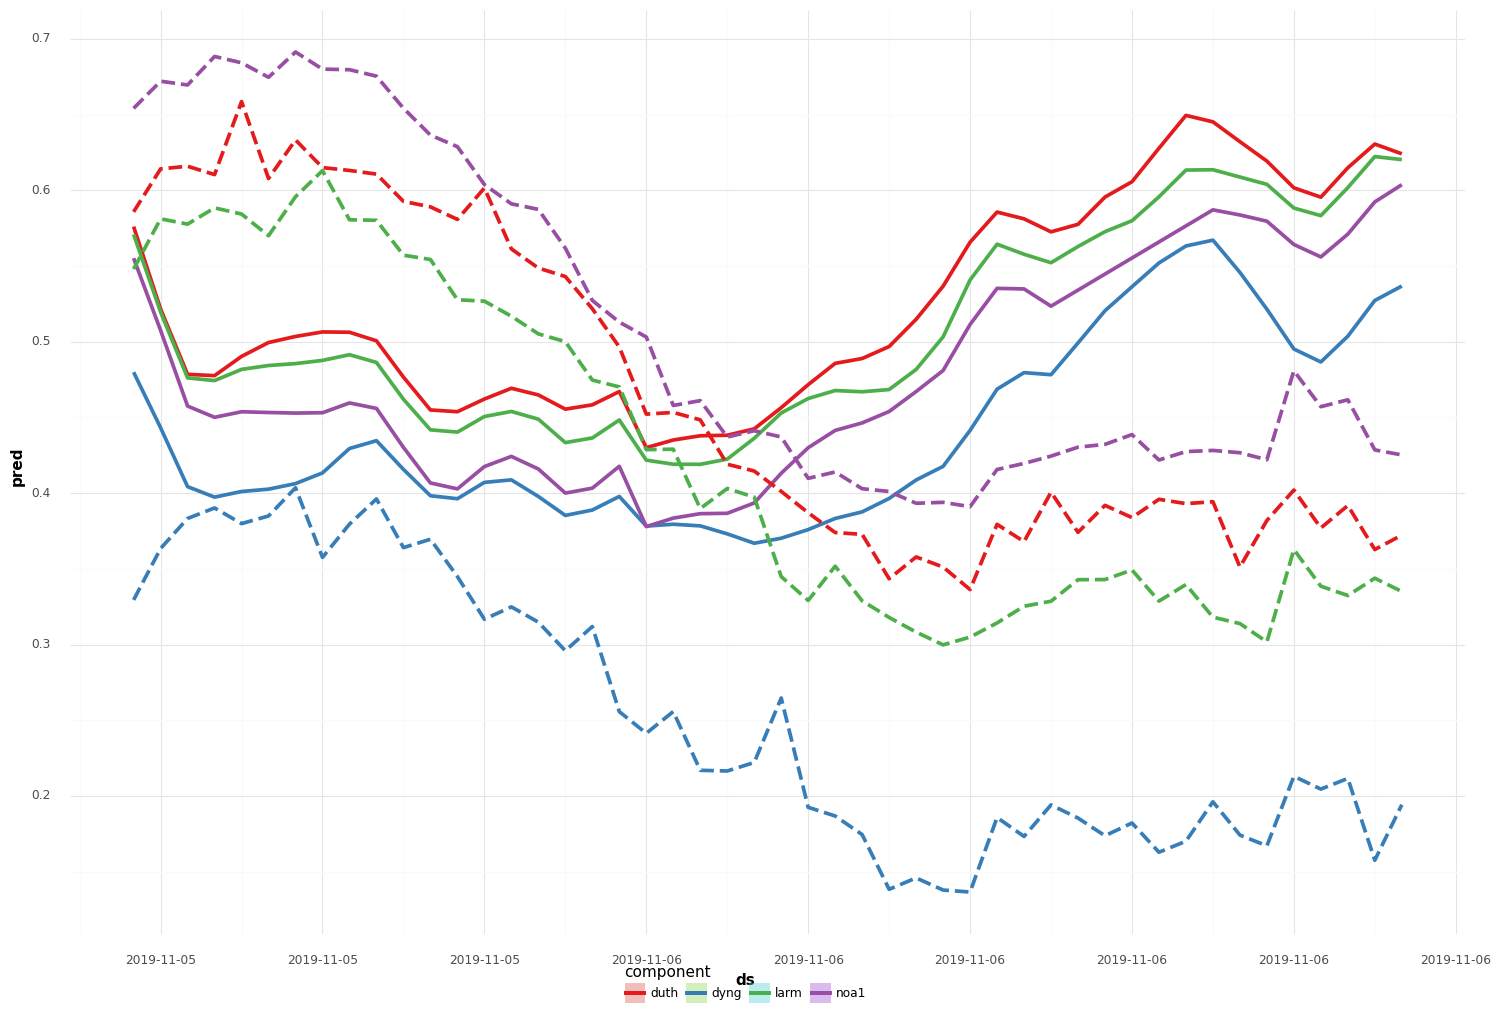

<ggplot: (8777135095336)>

In [47]:
from plotnine import ggplot, aes, facet_grid, labs, geom_line,geom_point, theme, geom_ribbon,theme_minimal,scale_color_brewer
from plotnine_prism import *
(
    ggplot(second_df.reset_index())  # What data to use
    + aes(x="ds")  # What variable to use
    + geom_ribbon(aes(y = "pred", ymin = "uncer_min", ymax = "uncer_max", fill = "component"), alpha = .4) 
    + geom_line(aes(y="current", color = "component"),size = 1.5)  # Geometric object to use for drawing
    + geom_line(aes(y="pred", color = "component"),linetype="dashed",size = 1.5 )  # Geometric object to use for drawing
    + theme_minimal() 
    +theme(legend_position="bottom", figure_size=(18, 12))
    + scale_color_brewer(type="qual", palette="Set1")
)

In [ ]:
from FCeV import METRICS
current_fcev.get_metrics_from_fc(df_fore["BASE"], METRICS.RMSE).mean().mean()

In [ ]:
current_fcev.get_metrics_from_fc(df_fore["SYNTH_2"]["8"], METRICS.RMSE).mean().mean()

In [ ]:
df_fore["BASE"].plot()

In [ ]:
df_fore["SYNTH_5"]["24"].plot()

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
train_day = dateutil.parser.parse("2018-09-30")
val_day = dateutil.parser.parse("2018-12-31")
series = TimeSeries.from_dataframe(df_ion[df_ion.index < val_day], fill_missing_dates=False, freq=freq)
series = series.astype(np.float32)
filler = MissingValuesFiller()
tec_series = filler.transform(series, method = "from_derivatives")

# Create training and validation sets:
train_tec, val_tec = tec_series.split_after(pd.Timestamp(train_day))

# We'll use the month as a covariate
scaler_tec = Scaler()
train_tec = scaler_tec.fit_transform(train_tec)
val_tec = scaler_tec.transform(val_tec)
tec_series = scaler_tec.transform(tec_series)



In [ ]:
widths = [4, 4, 3, 3, 6, 6, 6 ,6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 5, 7, 3, 4, 6, 4, 6, 5, 6, 6, 6, 9, 9, 9, 9, 3]
ion_data = pd.read_fwf('/home/carloscano/data/ion/ionosphere_parameters_data.txt', widths = widths, header=None)
id_ion = ["year", "doy", "hour", "id imf", "B scalar", "B vector", "Lat B", "Long B", "BY", "Bz", "SW Plasma Ta", "SW Proton", "SW Plasma Speed", "SW Plasma flow long", "SW Plasma Speed lat", "Alpha ratio", "Flow pressure", "Alfen", "Magneto", "Quasy", "Kp", "N sunspot", "Dst-index", "Ap index", "f107", "AE", "AL", "AU", "pc", "lyman", "Proton10", "Proton30", "Proton60", "Flux" ]
ion_data.columns = id_ion
strfmt = "{year}-{doy:0=3d}T{hour:0=2d}:00:00"

ion_data["datetime"] = ion_data.apply(lambda x: datetime.strptime(strfmt.format(year = int(x["year"]), doy = int(x["doy"]), hour = int(x["hour"])),"%Y-%jT%H:%M:%S"), axis = 1)

ion_data = ion_data.drop(["year", "doy", "hour"], axis = 1).set_index("datetime")

ion_data = ion_data[["Kp", "f107", "N sunspot"]]

In [ ]:
df_input

In [ ]:

ion_ts = TimeSeries.from_dataframe(ion_data[ion_data.index < val_day], fill_missing_dates=True, freq = "1H").resample(freq=freq)
ion_ts = ion_ts.astype(np.float32)
scaler_ion = Scaler()
ion_ts = scaler_ion.fit_transform(ion_ts)
# Create training and validation sets:
train_ion, val_ion = ion_ts.split_after(pd.Timestamp(train_day))

In [ ]:
my_model_TCN = TCNModel(
    input_chunk_length=48*5,
    output_chunk_length=48,
    n_epochs=40,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,    
    log_tensorboard=True,
     force_reset=True,
        pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },

)

my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Ion_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

In [ ]:
%%time

my_model_TCN.fit(
    train_tec,
    past_covariates=ion_ts,
    verbose=True,
)

In [ ]:
my_model_TCN.predict(100, past_covariates=ion_ts).plot()

In [ ]:
my_model_TCN.predict(10)

In [ ]:
from darts.ad import KMeansScorer,ForecastingAnomalyModel
scorer = KMeansScorer(k=5, window=20)

In [ ]:
ad_model = ForecastingAnomalyModel(my_model_TCN, scorer)
scorer.fit(train_tec)

In [ ]:
#anom_score = ad_model.score(val_tec,    past_covariates=ion_ts)

In [ ]:
%%time
ad_model.show_anomalies(val_tec,    past_covariates=ion_ts)

In [ ]:
train_tec.plot()

In [ ]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train_tec))
binary_anom = detector.detect(anom_score)

In [ ]:
import matplotlib.pyplot as plt

series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

In [ ]:
# Scale so that the largest value is 1.
# This way of scaling perserves the sMAPE
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [ ]:
for i in [10, 50, 100, 150, 250, 350]:
    plt.figure(figsize=(15, 5))
    all_series_fp32[i].plot(label="{}".format(i, lw=1))

In [ ]:
from darts.explainability.shap_explainer import ShapExplainer
from darts.models import RegressionModel

In [ ]:
model = RegressionModel(lags=24, lags_future_covariates = [24,24], output_chunk_length = 24)
model.fit(train_tec, future_covariates=ion_ts)

## DALEX

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (25, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 48 * 5
forecast_horizon = 48
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=1000,
    n_epochs=2,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
            pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)


In [ ]:
my_model.fit(train_tec, future_covariates=ion_ts, verbose=True)

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


In [ ]:
eval_model(my_model, 48, tec_series, val_ion)

In [ ]:
forecast_horizon = 48
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

In [ ]:
eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon * 10,
    start=training_cutoff,
    transformer=transformer,
)

In [ ]:
my_model = TCNModel(
    input_chunk_length=48*5,
    output_chunk_length=24,
    n_epochs=2,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,    
    log_tensorboard=True,
     force_reset=True,

)

In [ ]:
def retrain_func(pred_time, train_series, past_covariates, future_covariates):
    print(len(past_covariates))
    return True

In [ ]:
backtest = model_air.historical_forecasts(
    series=tec_filled,
    past_covariates=ion_ts,
    start=0.90,
    forecast_horizon=1,
    retrain=False,
    verbose=False,
    last_points_only = False,
)

In [ ]:
def plot_backtest(ts_actual, ts_backtest):
    ts_actual[ts_backtest.time_index].plot(label="actual")
    ts_backtest.plot(label="backtest (H=6)")
    plt.legend()


In [ ]:
plot_backtest(tec_filled, backtest[5])

In [ ]:
len(filled)*0.01

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape
from darts.datasets import AirPassengersDataset

In [ ]:
# Read data:
series = AirPassengersDataset().load()
series = series.astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [ ]:
my_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)
my_model.fit(train_transformed, val_series=val_transformed)